In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import binary_accuracy
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from gan import GAN

print("Tensorflow", tf.__version__)

from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    "Please install TensorFlow version 2.3.1 or older"

Tensorflow 2.2.0


In [9]:
class GAN():
    def __init__(self, generator, discriminator):        
        # discriminator
        self.D = discriminator
        self.G = generator

        self.bce = tf.keras.losses.BinaryCrossentropy()
        self.d_loss = {}
        self.g_loss = {}
        self.accuracy = {}        
        self.g_gradients = []

    def discriminator_loss(self, pred_fake, pred_real):
        real_loss = self.bce(tf.ones_like(pred_real), pred_real)
        fake_loss = self.bce(tf.zeros_like(pred_fake), pred_fake)
        
        d_loss = 0.5*(real_loss + fake_loss)
        return d_loss
    
    def generator_loss(self, pred_fake):
        g_loss = self.bce(tf.ones_like(pred_fake), pred_fake)
        return g_loss
    
    def train_step(self, g_input, real_input):

        with tf.GradientTape() as g_tape,\
             tf.GradientTape() as d_tape:
            # Feed forward
            fake_input = self.G(g_input)

            pred_fake = self.D(fake_input)
            pred_real = self.D(real_input)

            # Calculate losses
            d_loss = self.discriminator_loss(pred_fake, pred_real)
            g_loss = self.generator_loss(pred_fake)
            
            # Accuracy
            fake_accuracy = tf.math.reduce_mean(binary_accuracy(tf.zeros_like(pred_fake), pred_fake))
            real_accuracy = tf.math.reduce_mean(binary_accuracy(tf.ones_like(pred_real), pred_real))
            
            # backprop gradients
            gradient_g = g_tape.gradient(g_loss, self.G.trainable_variables)
            gradient_d = d_tape.gradient(d_loss, self.D.trainable_variables)
            
            gradient_g_l1_norm = [tf.norm(gradient).numpy() for gradient in gradient_g]
            self.g_gradients.append(gradient_g_l1_norm) 
            # update weights
            self.G_optimizer.apply_gradients(zip(gradient_g, self.G.trainable_variables))
            self.D_optimizer.apply_gradients(zip(gradient_d, self.D.trainable_variables))


        return g_loss, d_loss, fake_accuracy, real_accuracy
    
    def train(self, data_generator, 
                    z_generator,
                    g_optimizer, d_optimizer,
                    steps, interval=100):
        self.D_optimizer = d_optimizer
        self.G_optimizer = g_optimizer          
        val_g_input = next(z_generator)
        for i in range(steps):
            g_input = next(z_generator)
            real_input = next(data_generator)
            
            g_loss, d_loss, fake_accuracy, real_accuracy = self.train_step(g_input, real_input)
            self.d_loss[i] = d_loss.numpy()
            self.g_loss[i] = g_loss.numpy()
            self.accuracy[i] = 0.5*(fake_accuracy.numpy() + real_accuracy.numpy())
            if i%interval == 0:
                msg = "Step {}: d_loss {:.4f} g_loss {:.4f} Accuracy. real : {:.3f} fake : {:.3f}"\
                .format(i, d_loss, g_loss, real_accuracy, fake_accuracy)
                print(msg)
                
                fake_images = self.G(val_g_input)
                self.plot_images(fake_images)

    def plot_images(self, images):
        pass

In [10]:
def multimodal_normal(batch_size):
    while True:
        mean1 = [0, 0]
        cov1 = [[1, 0], 
                [0, 1]]
    
        mean2 = [5, 5]
        cov2 = [[0.2, -2], 
                [-2, 5]]

        x = []
        y = []
        means = [mean1, mean2]
        covs = [cov1, cov2]
        for _ in range(batch_size):
            i = np.random.randint(0,2)            
            x1, y1 = np.random.multivariate_normal(means[i], covs[i], 1).T
            x.append(x1)
            y.append(y1)


        samples = np.stack((x,y), axis=1)

        yield samples
        



(-5.0, 10.0)

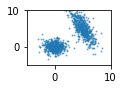

In [11]:
samples_gen = multimodal_normal(1000)
samples = next(samples_gen)
f, ax = plt.subplots(1, 1, figsize=(1*1.5, 1*1))

ax.scatter(samples[:,0], samples[:,1], s=1, alpha=0.5)
ax.set_xlim(-5, 10)
ax.set_ylim(-5, 10)

Step 0: d_loss 0.8858 g_loss 0.7003 Accuracy. real : 0.231 fake : 0.848
(50000, 2)


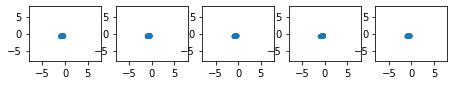

Step 1: d_loss 0.8053 g_loss 0.5635 Accuracy. real : 0.274 fake : 0.000
(50000, 2)


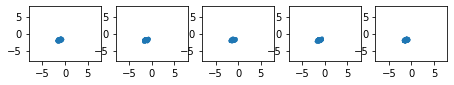

Step 2: d_loss 0.7019 g_loss 0.6158 Accuracy. real : 0.876 fake : 0.000
(50000, 2)


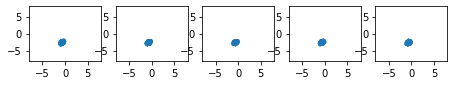

Step 3: d_loss 0.5869 g_loss 0.7668 Accuracy. real : 0.798 fake : 0.997
(50000, 2)


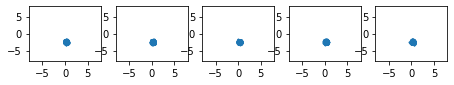

Step 4: d_loss 0.5621 g_loss 0.7733 Accuracy. real : 0.786 fake : 0.991
(50000, 2)


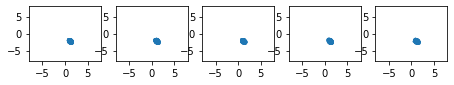

Step 5: d_loss 0.5645 g_loss 0.7431 Accuracy. real : 0.777 fake : 0.957
(50000, 2)


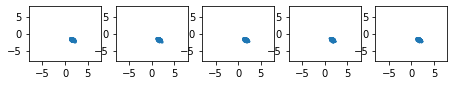

Step 6: d_loss 0.5532 g_loss 0.7573 Accuracy. real : 0.760 fake : 1.000
(50000, 2)


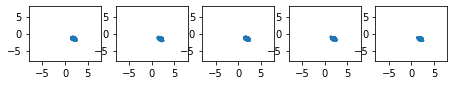

Step 7: d_loss 0.5306 g_loss 0.7990 Accuracy. real : 0.753 fake : 1.000
(50000, 2)


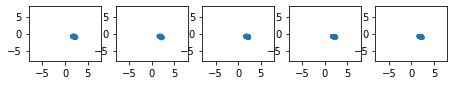

Step 8: d_loss 0.5393 g_loss 0.7708 Accuracy. real : 0.758 fake : 0.998
(50000, 2)


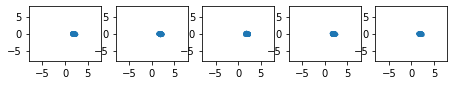

Step 9: d_loss 0.5924 g_loss 0.6602 Accuracy. real : 0.755 fake : 0.099
(50000, 2)


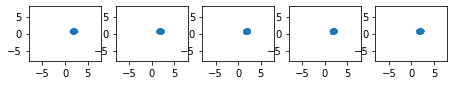

Step 10: d_loss 0.6446 g_loss 0.5731 Accuracy. real : 0.748 fake : 0.000
(50000, 2)


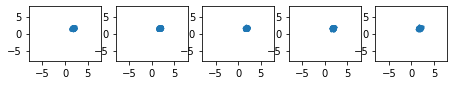

Step 11: d_loss 0.7205 g_loss 0.4827 Accuracy. real : 0.735 fake : 0.000
(50000, 2)


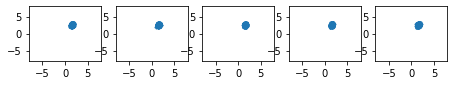

Step 12: d_loss 0.8106 g_loss 0.4032 Accuracy. real : 0.711 fake : 0.000
(50000, 2)


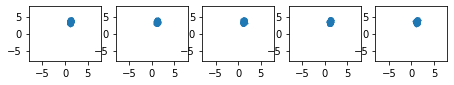

Step 13: d_loss 0.8677 g_loss 0.3672 Accuracy. real : 0.699 fake : 0.000
(50000, 2)


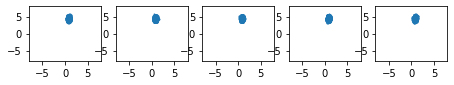

Step 14: d_loss 0.8569 g_loss 0.3984 Accuracy. real : 0.676 fake : 0.000
(50000, 2)


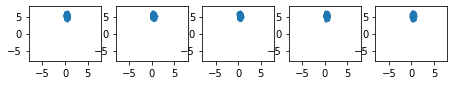

Step 15: d_loss 0.8024 g_loss 0.4805 Accuracy. real : 0.653 fake : 0.000
(50000, 2)


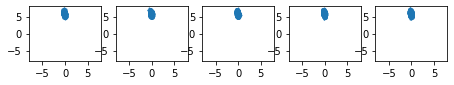

Step 16: d_loss 0.7144 g_loss 0.6328 Accuracy. real : 0.608 fake : 0.000
(50000, 2)


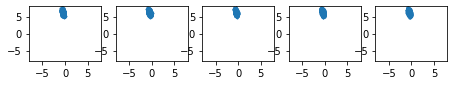

Step 17: d_loss 0.6277 g_loss 0.8210 Accuracy. real : 0.548 fake : 1.000
(50000, 2)


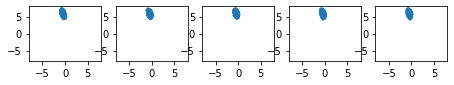

Step 18: d_loss 0.5636 g_loss 0.9891 Accuracy. real : 0.534 fake : 1.000
(50000, 2)


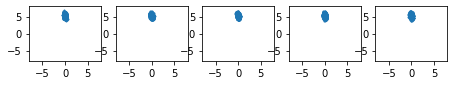

Step 19: d_loss 0.5411 g_loss 1.0220 Accuracy. real : 0.558 fake : 1.000
(50000, 2)


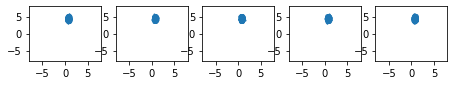

In [12]:
class VanillaGan(GAN):
    def __init__(self, z_dim, input_shape):
        
        discriminator = self.Discriminator(input_shape)
        generator = self.Generator(z_dim)
        
        GAN.__init__(self, generator, discriminator)
        
    def Discriminator(self, input_shape):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=input_shape))
        model.add(layers.Dense(200, activation='relu'))
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        return model

    def Generator(self, z_dim):
        model = tf.keras.Sequential()
        model.add(layers.Input(shape=[z_dim]))
        model.add(layers.Dense(200, activation='relu'))
        model.add(layers.Dense(50, activation='relu'))
        model.add(layers.Dense(2))
        return model        
    
    def plot_images(self, images):   
        grid_row = 1
        grid_col = 5
        f, ax = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.5, grid_row*1))
        print(images.shape)
        for col in range(grid_col):
            ax[col].scatter(images[col*10000:(col+1)*10000,0], 
                          images[col*10000:(col+1)*10000,1], s=1)
            ax[col].set_xlim(-8, 8)
            ax[col].set_ylim(-8, 8)
            #axarr[col].axis('off') 
        plt.show()

z_dim = 100
image_shape = (2)
batch_size = 50000

def z_generator(batch_size, z_dim):
    while True:
         yield tf.random.uniform((batch_size, z_dim))
            
z_gen = z_generator(batch_size, z_dim)

vanilla_gan = VanillaGan(z_dim, image_shape)
vanilla_gan.train(multimodal_normal(batch_size), z_gen,
                    RMSprop(1e-3), RMSprop(1e-3),
                    20, 1)